In [1]:
import requests
import pandas as pd 
import json
import numpy as np
from zmq.backend import first

In [105]:
ticker = 'MSFT'
params = {
    'interval' : '1d',
    'start_date' : '2010-01-01',
    'end_date' : '2024-01-01',
}
response = requests.get(f"http://localhost:8000/dataset_manager/get_stock_data/{ticker}", params=params)

df = pd.DataFrame(response.json()).T

In [106]:
df.iloc[2044:2045]['pctChgclose+2']

2018-02-15 00:00:00+00:00    0.78261
Name: pctChgclose+2, dtype: float64

In [107]:

url = 'http://localhost:8000/sequenceset_manager/get_sequence_data'
# features = ['pctChgclose', 'pctChgvolume', 'opHi', 'opCl','hiCl','loCl','opLo',"pctDiff+ema5_close", "pctDiff+ema10_close", "pctDiff+ema20_close",'pctDiff+ema50_close', 'pctDiff+ema100_close',
# 'pctDiff+ema200_close','pctDiff+bb_high_close10', 'pctDiff+bb_low_close10', 'pctDiff+smaVol10_volume', 'pctDiff+smaVol20_volume', 'pctChgClOp', 'macd_signal','bb_indicator20',"bb_indicator50",
#             ]
# features = ['open', 'high', 'low', 'close', 'volume']

# features = ['pctChgclose','pctChgvolume','opHi', 'opCl','hiCl','loCl','opLo']
# target_features = ['pctChgclose+{}'.format(i) for i in range(1, 2) ]
target_features = ['cumPctChg+{}'.format(i) for i in range(2, 3) ]

In [128]:
tickers = ['BB' ]
# tickers = ['AAPL']
sequence_lengths = [20]
all_sequences = []

all_params = []

for ticker in tickers:
    for sequence_length in sequence_lengths:
        all_params.append({
            'ticker': ticker,
            'features': target_features,
            'interval': '1d',
            'sequence_length': sequence_length
        })
for params in all_params:

    response = requests.get(url, params=params)
    if response.status_code == 200:
        try:
            data = response.json()
            all_sequences.append(data)
        except json.JSONDecodeError as e:
            print(f"Failed to decode JSON: {e}")
            print("Response text:", response.text)
    else:
        print(f"Request failed with status code {response.status_code}")

In [129]:
sequences = all_sequences[0]

In [130]:
print(len(sequences))

6420


In [131]:
y = np.zeros((len(sequences), 1))
for i, sequence in enumerate(sequences):
    y[i] = sequence['sliced_data'][0]

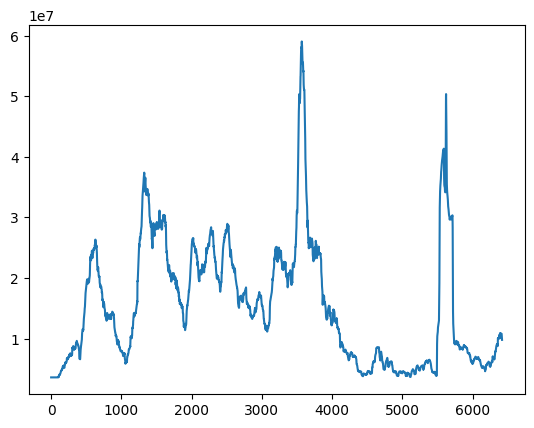

In [132]:
# plot y 
import matplotlib.pyplot as plt
plt.plot(y)

In [78]:
import os
import django

# Set the Django settings module (replace 'your_project_name' with the actual project name)
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'TradeLens.settings')

# Set up Django
django.setup()
import sys

# Replace this path with the path to your Django project
sys.path.append('/Users/andrewpassero/Documents/TradeLensForcast')

In [79]:
from sequenceset_manager.models import StockSequence, FeatureDict
from asgiref.sync import sync_to_async

In [84]:
@sync_to_async
def get_first(index):
    seqs = StockSequence.objects.filter(ticker=ticker, sequence_length = 20).order_by('start_timestamp')
    print(len(seqs))
    return seqs[index], FeatureDict.objects.first()

In [85]:
async def main(index):
    obj, diction = await get_first(index)
    return obj, diction

In [86]:
index = 5
first, diction = await main(index)

9680


In [87]:
print(sequences[index]["ticker"])
print(sequences[index]["start_timestamp"])
print(sequences[index]["end_timestamp"])

MSFT
1986-03-20T00:00:00Z
1986-04-17T00:00:00Z


In [88]:
print(first.sequence_length)

20


In [89]:
feature_dict = diction.feature_dict
feature_dict = (sorted(feature_dict.items(), key=lambda item: item[1]))
feature_dict = dict(feature_dict)

In [90]:
arr = np.array(first.sequence_data).T

In [91]:
print(first.ticker)
print(first.start_timestamp)
print(first.end_timestamp)

MSFT
1986-03-20 00:00:00+00:00
1986-04-17 00:00:00+00:00


In [92]:
arr[:,feature_dict['close+1']]

KeyError: 'close+1'